<a href="https://colab.research.google.com/github/LeToyek/ML-Kelompok5-3H-Ceria-Cepat-Cendekiawan/blob/main/Kuis2/Kuis_2_ML_Kelompok_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kuis 2 - Machine Learning

# Kelompok 5
1. Abdul Basith Bahi
2. Bagus Rezky Adhyaksa
3. Maulana Arif Wijaya
4. Muhammad Dzaka Murran Rusid
5. Sely Ruli Amanda

## Import Library

In [194]:
import numpy as np
import imutils
import cv2
from imutils.contours import sort_contours
from google.colab.patches import cv2_imshow
import os

## Load Drive

In [195]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load Model

In [196]:
model = load_model('/content/drive/MyDrive/ML/model_ocr.h5')
# check summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 25, 25, 32)        544       
                                                                 
 max_pooling2d (MaxPooling2  (None, 12, 12, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 9, 9, 64)          32832     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 4, 4, 64)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dropout (Dropout)           (None, 1024)              0

## Menampilkan Citra Original

In [197]:
dir = "/content/drive/MyDrive/ML/KTP/"

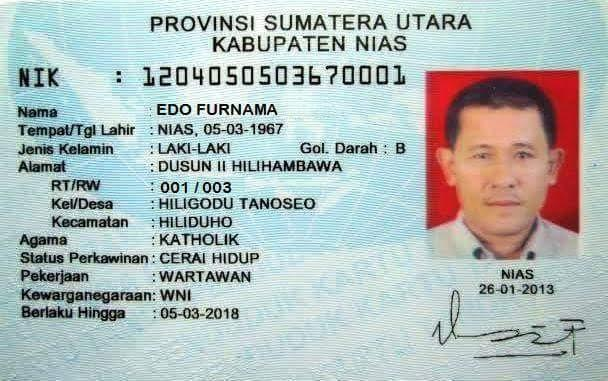

In [198]:
img = cv2.imread(dir + "ktp5.png")
# show image
cv2_imshow(img)

## Preprocessing

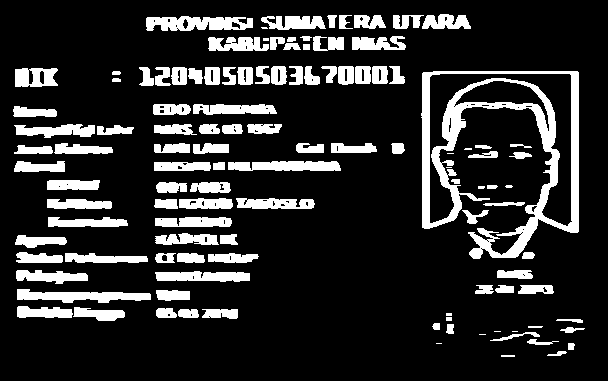

In [199]:
res = img.copy()

res = cv2.GaussianBlur(res, (5, 5), 0)
ret, res = cv2.threshold(res, 100, 255, cv2.THRESH_BINARY, cv2.THRESH_OTSU)
res_gray = cv2.cvtColor(res, cv2.COLOR_BGR2GRAY)
res = cv2.adaptiveThreshold(res_gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 9)
# res = cv2.adaptiveThreshold(res, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 9)

# inverse karena morphology dilasi&erosi bg hitam, fg putih
res = 255 - res

# dilate di sumbu horizontal ke kanan buat gabungin kata, coba2
kernel = np.array([
    [0, 0, 0],
    [0, 1, 1],
    [0, 0, 0]
], np.uint8)
res = cv2.dilate(res, kernel, iterations=5)

cv2_imshow(res)

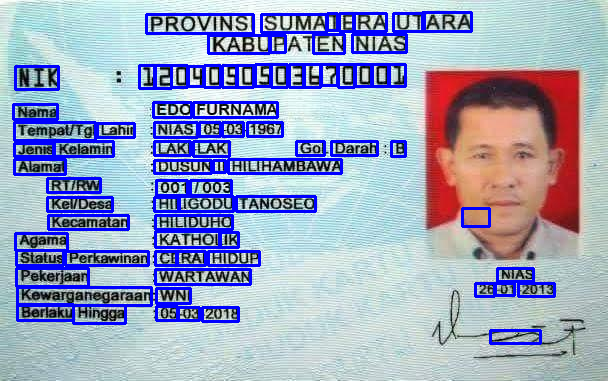

(381, 608, 3)


In [200]:
import imutils
import cv2
import numpy as np
from keras.models import load_model

# Define function for contour detection
def find_contours(img):
    conts = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    conts = imutils.grab_contours(conts)

    # print(len(conts))
    if len(conts) <= 0:
      return []

    conts = sort_contours(conts, method='left-to-right')[0]

    return conts

def extract_roi(img, x, y, w, h):
    roi = img[y:y+h, x:x+w]
    return roi

def thresholding(img):
    thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    return thresh

def resize_img(img, w, h):
    if w > h:
        resized = imutils.resize(res, width=28)
    else:
        resized = imutils.resize(res, height=28)

    (h, w) = resized.shape

    dX = int(max(0, 28 - w) / 2.0)
    dY = int(max(0, 28 - h) / 2.0)

    filled = cv2.copyMakeBorder(resized, top=dY, bottom=dY, right=dX, left=dX, borderType=cv2.BORDER_CONSTANT, value=(0,0,0))
    filled = cv2.resize(filled, (28,28))

    return filled

def normalization(img):
    img = img.astype('float32') / 255.0
    img = np.expand_dims(img, axis=-1)
    return img

def process_box(gray, x, y, w, h):
    roi = extract_roi(gray, x, y, w, h)
    thresh = thresholding(roi)
    (h, w) = thresh.shape
    resized = resize_img(thresh, w, h)
    normalized = normalization(resized)
    return (normalized, (x, y, w, h))

# Load image (pastikan Anda sudah mendefinisikan 'img' sebelumnya)
(imh, imw, _) = img.shape

min_w, max_w = 9, imw
min_h, max_h = 8, 145
img_copy = img.copy()

# Find contours
conts = find_contours(res.copy())

# Inisialisasi variabel detected_char
detected_char = []

texts_roi = []

# Loop untuk deteksi bounding box dan ekstraksi karakter
for c in conts:
    (x, y, w, h) = cv2.boundingRect(c)

    if (w >= min_w and w <= max_w) and (h >= min_h and h <= max_h):
      vp = 2
      y = y - vp
      h = h + vp * 2

      cv2.rectangle(img_copy, (x,y), (x+w, y+h), (255,0,0), 2)
      detected_char.append(process_box(res_gray, x, y, w, h))
      roi = img[y:y+h, x:x+w]
      texts_roi.append(roi)

cv2_imshow(img_copy)
print(img.shape)

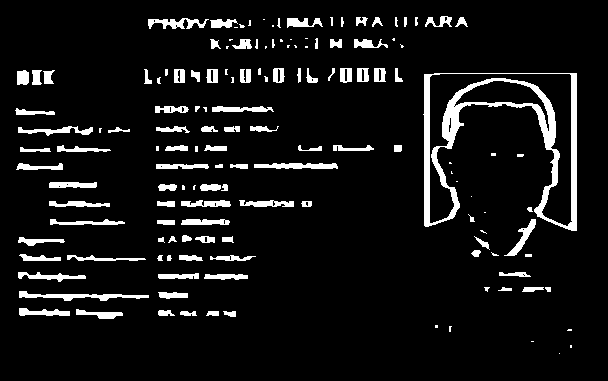

In [201]:
def visualize_contours(img, contours):
    img_with_contours = img.copy()
    cv2.drawContours(img_with_contours, contours, -1, (0, 255, 0), 2)
    cv2_imshow(img_with_contours)

img_example = res.copy()
contours_example = find_contours(img_example)
visualize_contours(img_example, contours_example)


In [202]:
for roi in texts_roi:
  cv2_imshow(roi)

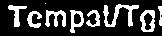

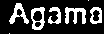

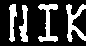

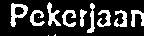

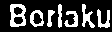

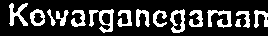

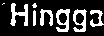

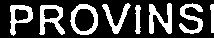

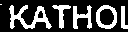

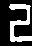

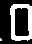

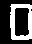

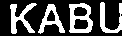

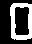

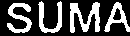

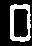

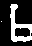

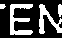

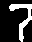

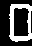

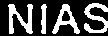

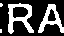

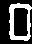

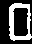

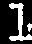

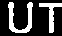

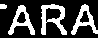

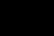

In [203]:

min_w, max_w = 5, 50
min_h, max_h = 14, 50

def extract_chars(img_ori):
  img_ori = cv2.resize(img_ori, (0, 0), fx = 2, fy = 2)
  img = cv2.cvtColor(img_ori, cv2.COLOR_BGR2GRAY)
  img = cv2.GaussianBlur(img, (7, 7), 0)
  # _, img = cv2.threshold(img, 250, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
  img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 9)
  # print(res)

  img = 255- img

  # cv2_imshow(img)
  # img = cv2.dilate(img, kernel, iterations=5)
  conts = find_contours(img)

  cv2_imshow(img)
  # img = 255 - img


  # print(f'img {img}')

  chars = []

  for c in conts:
    (x, y, w, h) = cv2.boundingRect(c)

    if(w >= min_w and w <= max_w) and (h >= min_h and h <= max_h):
      # cv2.rectangle(img_ori, (x,y), (x+w, y+h), (255,0,0), 2)
      chars.append(img_ori[y:y+h, x:x+w])

  return chars
  # cv2_imshow(img)
  # cv2_imshow(img_ori)

for i in range(len(texts_roi)):
  chars = extract_chars(texts_roi[i])

  for c in chars:
    cv2_imshow(c)

In [204]:
def resize_img(img, w, h):
  if w > h:
    resized = imutils.resize(img, width=28)
  else:
    resized = imutils.resize(img, height=28)

  # (w, h) = resized.shape
  (h, w) = resized.shape

  # Calculate how many pixels need to fill char image
  dX = int(max(0, 28 - w) / 2.0)
  dY = int(max(0, 28 - h) / 2.0)

  filled = cv2.copyMakeBorder(resized, top=dY, bottom=dY, right=dX, left=dX, borderType=cv2.BORDER_CONSTANT, value=(0,0,0))
  filled = cv2.resize(filled, (28,28))

  return filled

1/1 [==============================] - 0s 36ms/step
OCR Result:  ['N', '8', 'm', 'a']


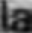

1/1 [==============================] - 0s 36ms/step
OCR Result:  ['A', '&', 'm', 'a']


1/1 [==============================] - 0s 38ms/step
OCR Result:  ['J', 'c', 'n', 'r']


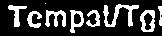

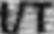

1/1 [==============================] - 0s 46ms/step
OCR Result:  ['I', 'e', 'm', 'P', '8', 'A', 'g']


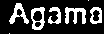

1/1 [==============================] - 0s 35ms/step
OCR Result:  ['A', 'g', 'a', 'M', 'a']


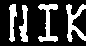

1/1 [==============================] - 0s 37ms/step
OCR Result:  ['|', 'i', 'I', 'K']


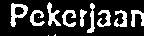

1/1 [==============================] - 0s 37ms/step
OCR Result:  ['P', 'e', 'k', 'G', "'", 'j', 'a', 'a', 'n']


1/1 [==============================] - 0s 45ms/step
OCR Result:  ['S', 'l', 'a', 'l', 'U']


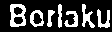

1/1 [==============================] - 0s 23ms/step
OCR Result:  ['8', 'Q', 'l', 'a', 'k', 'U']


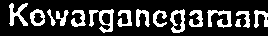

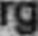

1/1 [==============================] - 0s 29ms/step
OCR Result:  ['K', 'A', 'm', 'Y', 'a', 'V', '8', 'n', '8', 'g', 'a', 'Q', 'A', 'n']


1/1 [==============================] - 0s 50ms/step
OCR Result:  ['K', 'e', 'v', 'D', 'e']


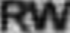

1/1 [==============================] - 0s 38ms/step
OCR Result:  ['R', 'I', '/', 'M']


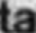

1/1 [==============================] - 0s 37ms/step
OCR Result:  ['K', 'e', 'k', 'M', '8', 'w', 'N']


1/1 [==============================] - 0s 36ms/step
OCR Result:  ['K', 'E', '!', 'a', 'm', 'R']


1/1 [==============================] - 0s 40ms/step
OCR Result:  ['R', 'e', '(', 'k', 'A', 'N', 'n', 'A', 'n']


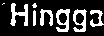

1/1 [==============================] - 0s 37ms/step
OCR Result:  ['H', 'n', 'g', 'g', '8']


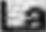

1/1 [==============================] - 0s 35ms/step
OCR Result:  ['G', 'h', '(']


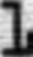

1/1 [==============================] - 0s 36ms/step
OCR Result:  ['l']


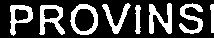

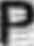

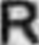

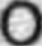

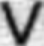

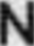

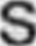

1/1 [==============================] - 0s 56ms/step
OCR Result:  ['P', 'R', 'O', 'V', '|', 'N', 'S']


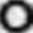

1/1 [==============================] - 0s 40ms/step
OCR Result:  ['E', 'D', 'O']


In [210]:
# characters = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
characters = [
    '!', '"', '#', '$', '%', '&', "'", '(', ')', '*',
    '+', ',', '-', '.', '/', '0', '1', '2', '3', '4',
    '5', '6', '7', '8', '9', ':', ';', '<', '=', '>',
    '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H',
    'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R',
    'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'W', 'X',
    'Y', 'Z', '!', '"', 'a', 'b', 'c', 'd', "e", 'f',
    'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p',
    'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z',
    '{', '|', '}', '~']

def recognize_chars_img(chars, model_font):
    box = []

    img_preview = []
    for c in chars:
        img = cv2.cvtColor(c.copy(), cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img, (0, 0), fx = 1.5, fy = 1.5)

        cv2_imshow(img)

        img = cv2.threshold(img, 100, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

        pad = 5
        img = cv2.copyMakeBorder(img,pad, pad, pad, pad,   borderType=cv2.BORDER_CONSTANT, value=(0,0,0))

        kernel = np.array([
            [1, 1, 1],
            [1, 1, 1],
            [1, 1, 1]
        ], np.uint8)
        img = cv2.erode(img, kernel, iterations=1)
        # cv2_imshow(img)

        (h, w) = img.shape
        img = resize_img(img, w, h)

        # cv2_imshow(img)


        # Normalisasi
        img = img.astype('float32') / 255.0
        img = np.expand_dims(img, axis=-1)

        box.append(img)

    if not len(box):
        return []

    data = np.array(box, dtype='float32')

    # Tampilkan citra-citra yang akan diolah
    # cv2_imshow(np.hstack([cv2.resize(c, (50, 50)) for c in chars]))

    preds = model.predict(data)

    # print(preds)

    recognized_chars = []
    for p in preds:
        char_idx = np.argmax(p)
        if 0 <= char_idx < len(model_font):
            recognized_chars.append(model_font[char_idx])
            # print(char_idx)
            # print(p[char_idx])
        else:
            recognized_chars.append('UNKNOWN')
    print("OCR Result: ", recognized_chars)

# Ganti ini dengan model font yang sudah Anda buat
model_font = characters

for i in range(20):
    chars = extract_chars(texts_roi[i])

    res = recognize_chars_img(chars, model_font)

